## Workspace setup

This notebook take .root file and converts it to .tfrecord.

There are two types of conversion.

<strong>XYZ</strong><br>
 The output data format is (512, 256, 3) and (, 9) for image and target respectively. This way target is in XYZ coordinates while image in UVWT which leads to model learning the mapping from UVWT to XYZ and keypoints detection at once.

<strong>UVWT</strong><br>
 Image is (3, 512, 256) and target (3, 6). First dimension is batchsize - 3 samples for 3 projections: (U,T), (V,T), (W, T). This way model learns the keypoint detection only.

In [1]:
from multiprocessing import Process, Queue
import tensorflow as tf
import numpy as np
from os.path import isfile
import io_functions as io


from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.io import TFRecordWriter, TFRecordOptions
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
dataPath = '/scratch/pszyc'

2023-12-23 07:06:51.187273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TFRecord creation

In [2]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize(charge_array, target):
  feature = {'myChargeArray' : _bytes_feature(tf.io.serialize_tensor(charge_array)),
             'target' : _bytes_feature(tf.io.serialize_tensor(target))}
  example = tf.train.Example(features=tf.train.Features(feature=feature))
  return example.SerializeToString()


In [ ]:
def conversion_xyz(filename, queue):
    options = TFRecordOptions(compression_type='GZIP')
    writer = TFRecordWriter(filename, options=options)
    while True:
        item = queue.get()
        if item == None:
            break
        charge_array, target = item
        charge_array= io.proc_features(charge_array)
        
        example = serialize(charge_array, target)
        writer.write(example)

In [3]:
def XYZtoUVWT(data):
    referencePoint = tf.constant([-138.9971, 98.25])
    phi = np.pi/6.0
    stripPitch = 1.5
    f = 1.0/25*6.46
    u = -(data[:, 1]-99.75)
    v = (data[:, 0]-referencePoint[0]) * np.cos(phi) - (data[:, 1]-referencePoint[1]) * np.sin(phi)
    w = (data[:, 0]-referencePoint[0]) * np.cos(-phi) - (data[:, 1]-referencePoint[1]) * np.sin(-phi) + 98.75
    t = data[:, 2]/f + 256
    u/=stripPitch
    v/=stripPitch
    w/=stripPitch
    return tf.stack([u,v,w,t], axis=0).T

def conversion_uvwt(filename, queue):
    options = TFRecordOptions(compression_type='GZIP')
    writer = TFRecordWriter(filename, options=options)
    scale = 100
    n_projections = 3
    while True:
        item = queue.get()
        if item == None:
            break
        myChargeArray, target = item
        charge_array= io.proc_features(myChargeArray)
        charge_array = tf.transpose(charge_array, perm = [0, 3, 1, 2])
        uvwt_1 = XYZtoUVWT(scale*target[:, 0:3])
        uvwt_2 = XYZtoUVWT(scale*target[:, 3:6])
        uvwt_3 = XYZtoUVWT(scale*target[:, 6:9])

        points = []
        for i in range(n_projections):
          points.append([
              uvwt_1[:, 3], uvwt_1[:, i],
              uvwt_2[:, 3], uvwt_2[:, i],
              uvwt_3[:, 3], uvwt_3[:, i]
          ])
        points = np.stack(points, axis = 1).T
        for index in range(points.shape[0]):
          example = serialize(charge_array[index], points[index])
          writer.write(example)

In [4]:
def process_and_save(output_files, datasetGenerator, conversion_function):
    nFiles = len(output_files)
                 
    for file in output_files:
        if isfile(file):
            raise Exception('output file already exists')
    
    if __name__ == '__main__':
        processes = []
        q = Queue(2*nFiles)

        for name in output_files:
            p = Process(target=conversion_function, args=(name, q))
            processes.append(p)
            p.start()
            print(p.name + ' started')
    
        counter = 0
        for item in datasetGenerator:
            q.put(item)
            counter+=1
            if counter%100 == 0:
                print(f'read {counter} batches')
    
        for _ in range(nFiles):
            q.put(None)
        
        for p in processes:
            p.join()
            print(p.name + ' done')

### Trainset

In [6]:
file = "out_random_sigma-001"
batchSize = 5
nFiles = 5 # number of output files, equal to number of processes

input_files = [f'{dataPath}/{file}.root:TPCData']
output_files = [f"{dataPath}/data_xyz/{file}-part-{i}.tfrecord" for i in range(nFiles)]
datasetGenerator = io.minimal_generator(files=input_files, batchSize=batchSize)

In [7]:
%%time
process_and_save(output_files, datasetGenerator, conversion)

Process-1 started
Process-2 started
Process-3 started
Process-4 started
Process-5 started


2023-12-23 07:07:46.929093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)
2023-12-23 07:07:46.929149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)
2023-12-23 07:07:47.126533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)
2023-12-23 07:07:47.239181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)
2023-12-23 07:07:47.418567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


read 100 batches
read 200 batches
read 300 batches
read 400 batches
read 500 batches
read 600 batches
read 700 batches
read 800 batches
read 900 batches
read 1000 batches
read 1100 batches
read 1200 batches
read 1300 batches
read 1400 batches
read 1500 batches
read 1600 batches
read 1700 batches
read 1800 batches
read 1900 batches
read 2000 batches
read 2100 batches
read 2200 batches
read 2300 batches
read 2400 batches
read 2500 batches
read 2600 batches
read 2700 batches
read 2800 batches
read 2900 batches
read 3000 batches
read 3100 batches
read 3200 batches
read 3300 batches
read 3400 batches
read 3500 batches
read 3600 batches
read 3700 batches
read 3800 batches
read 3900 batches
read 4000 batches
read 4100 batches
read 4200 batches
read 4300 batches
read 4400 batches
read 4500 batches
read 4600 batches
read 4700 batches
read 4800 batches
read 4900 batches
read 5000 batches
read 5100 batches
read 5200 batches
read 5300 batches
read 5400 batches
read 5500 batches
read 5600 batches
r

### Testset

In [16]:
file = "out_random_sigma2k2mm"
batchSize = 5
nFiles = 5 # number of output files, equal to number of processes

input_files = [f'{dataPath}/{file}.root:TPCData']
output_files = [f"{dataPath}/data_xyz/{file}-part-{i}.tfrecord" for i in range(nFiles)]
datasetGenerator = io.minimal_generator(files=input_files, batchSize=batchSize)

In [17]:
%%time
process_and_save(output_files, datasetGenerator, conversion)

Process-16 started
Process-17 started
Process-18 started
Process-19 started
Process-20 started
read 100 batches
read 200 batches
read 300 batches
read 400 batches
Process-16 done
Process-17 done
Process-18 done
Process-19 done
Process-20 done
CPU times: user 33.6 s, sys: 19.4 s, total: 53 s
Wall time: 45.9 s


### Validation set

In [18]:
file = "out_random_sigma"
batchSize = 5
nFiles = 5 # number of output files, equal to number of processes

input_files = [f'{dataPath}/{file}.root:TPCData']
output_files = [f"{dataPath}/data_xyz/{file}-part-{i}.tfrecord" for i in range(nFiles)]
datasetGenerator = io.minimal_generator(files=input_files, batchSize=batchSize)

In [19]:
%%time
process_and_save(output_files, datasetGenerator, conversion)

Process-21 started
Process-22 started
Process-23 started
Process-24 started
Process-25 started
read 100 batches
read 200 batches
Process-21 done
Process-22 done
Process-23 done
Process-24 done
Process-25 done
CPU times: user 17.3 s, sys: 9.64 s, total: 26.9 s
Wall time: 23.5 s


# Read TFRecord xyz

In [20]:
import plotting_functions as plf

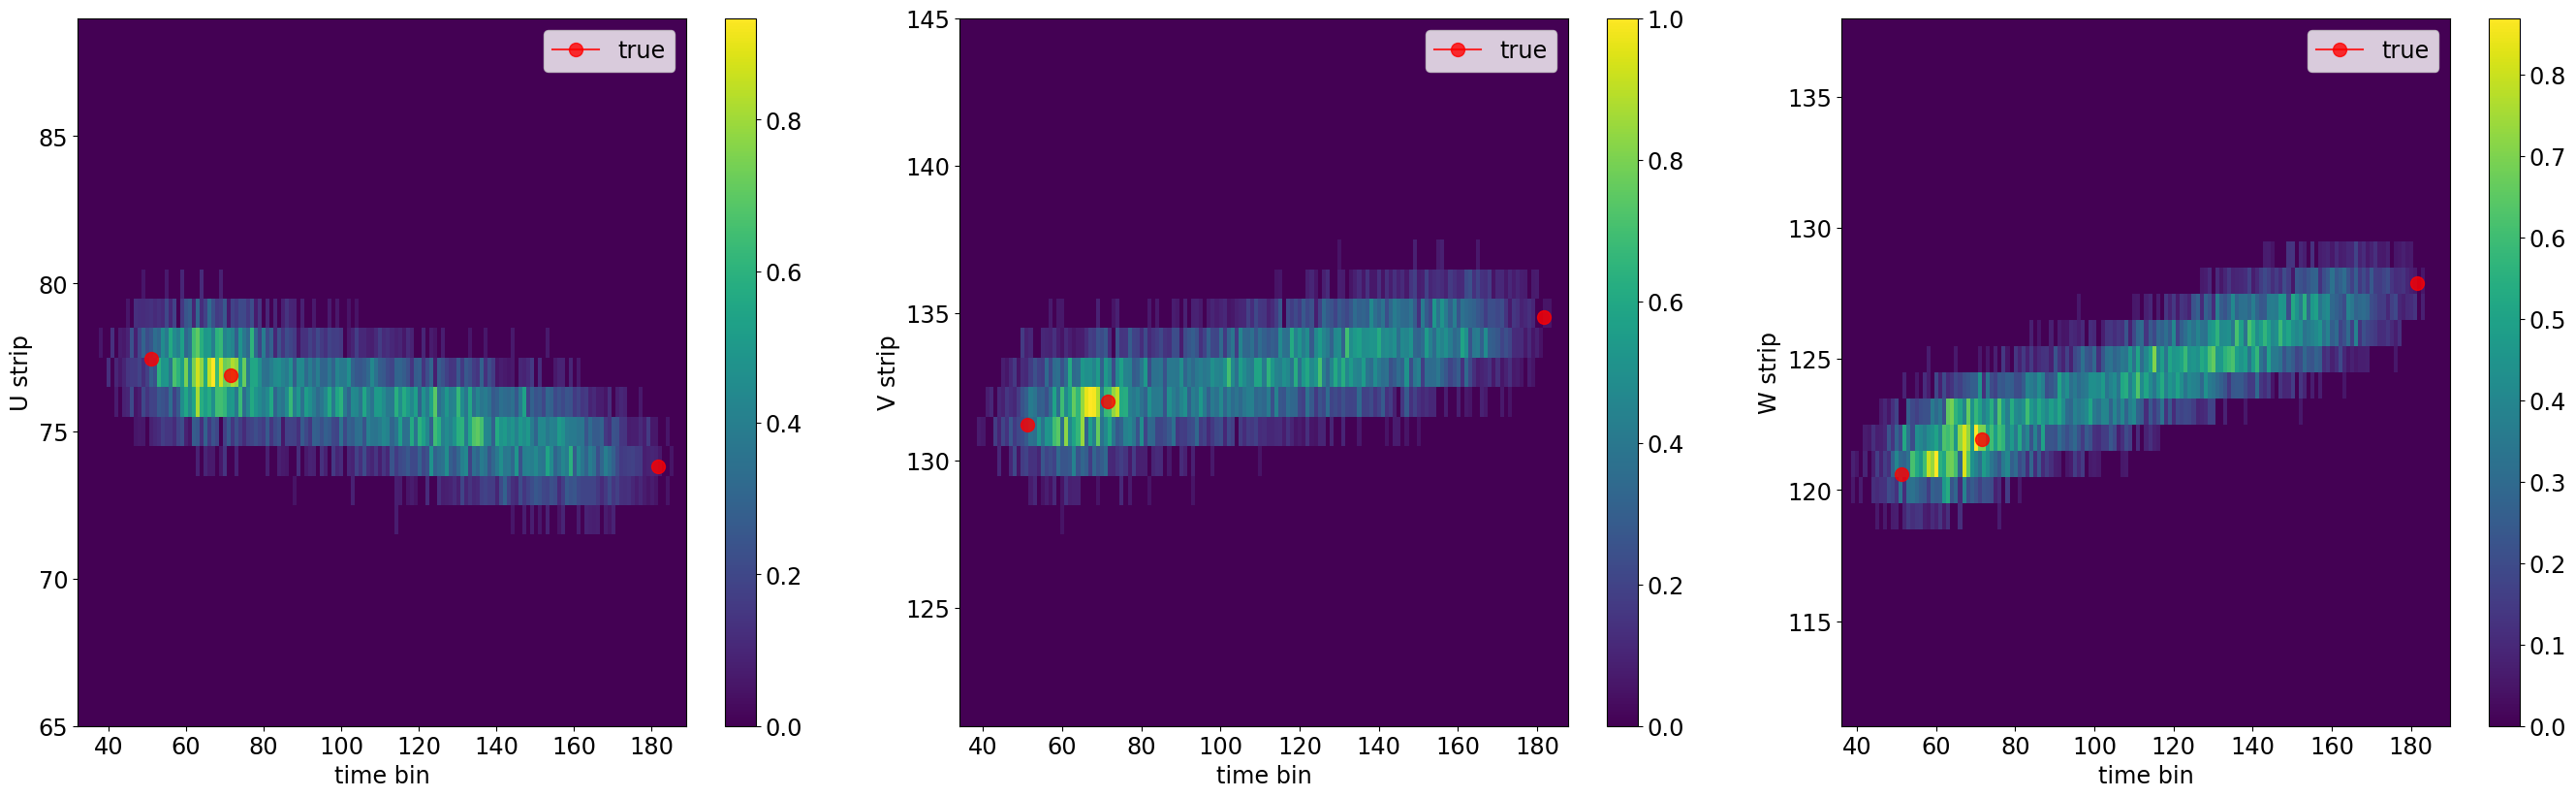

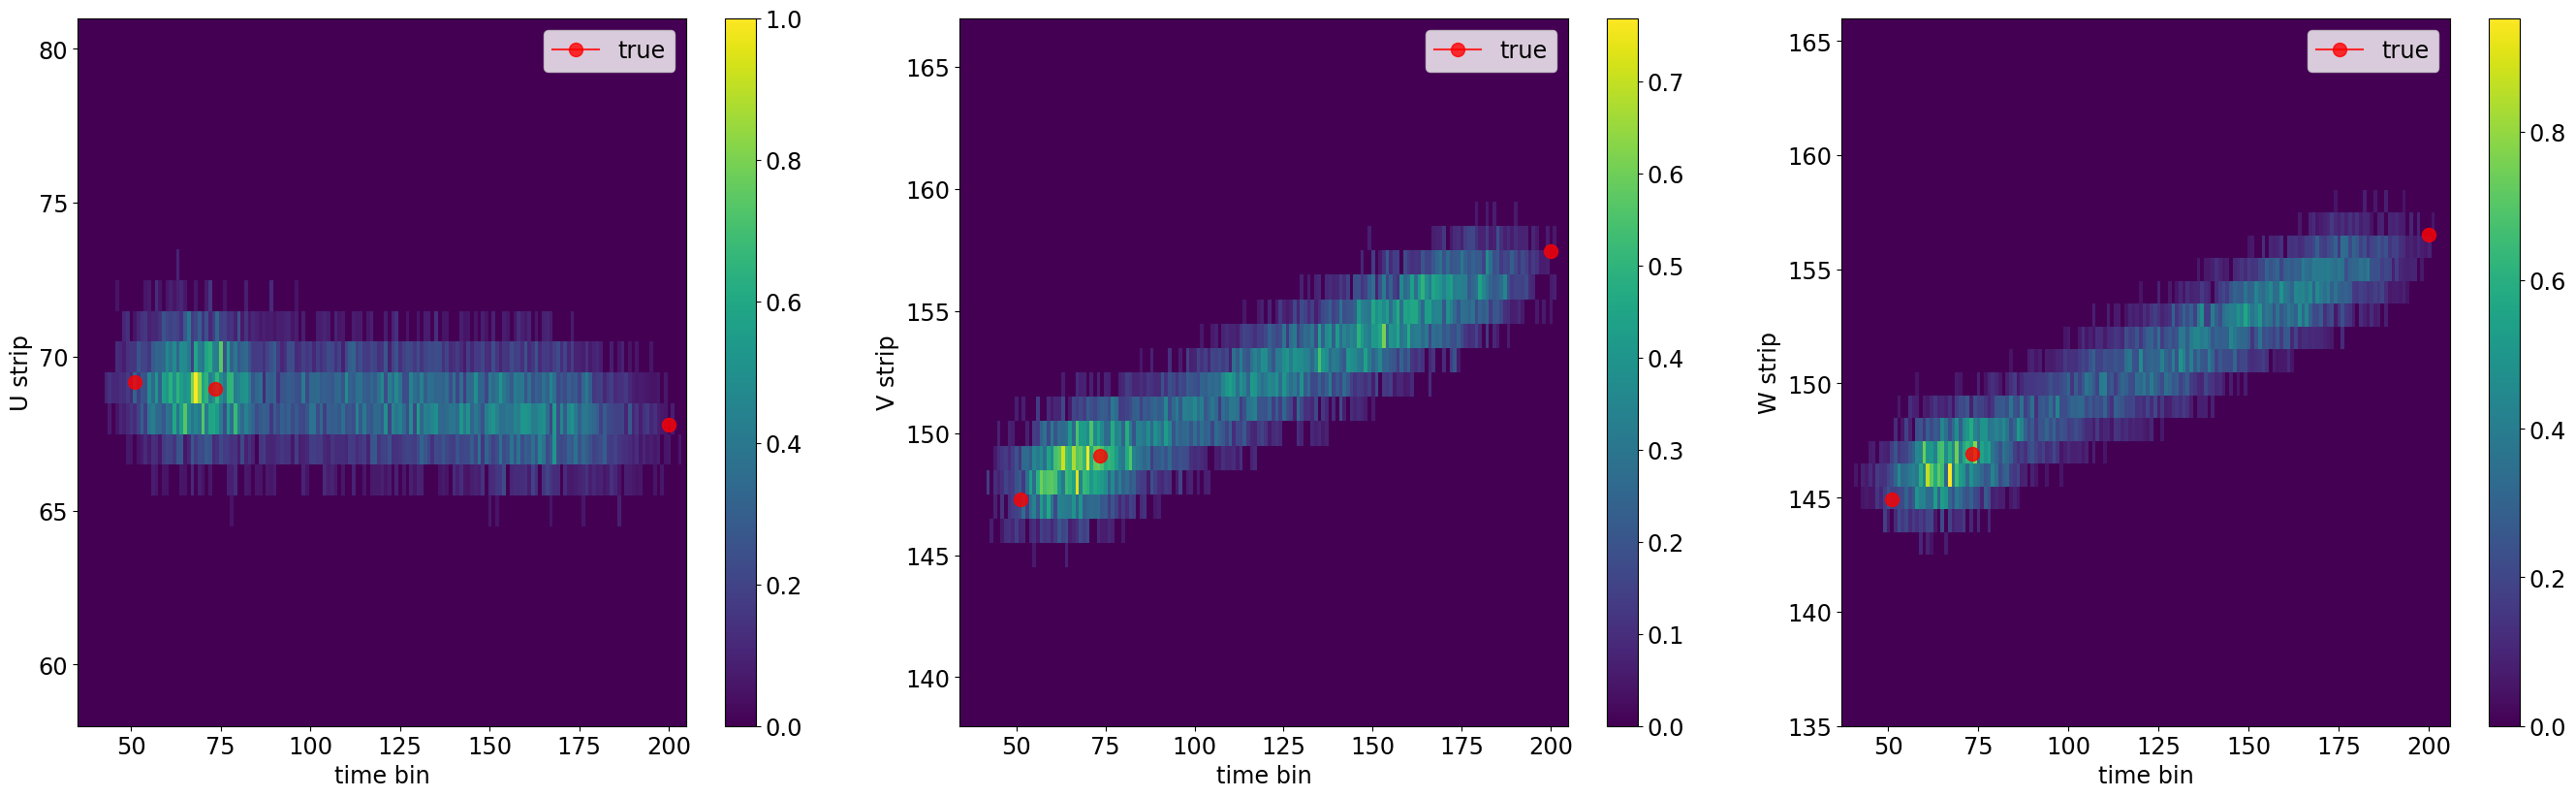

In [21]:
filenames = [f"{dataPath}/data_xyz/out_random_sigma-001-part-{i}.tfrecord" for i in range(5)]
train_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=5)
test_dataset = tf.data.TFRecordDataset(f'{dataPath}/data_xyz/out_random_sigma2k2mm-part-0.tfrecord', compression_type='GZIP')
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),

}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)
    
    return charge, target

def shape_items(charge, target):
    charge.set_shape(charge_shape)
    target.set_shape(target_shape)
    return charge, target

train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.batch(batchSize)
test_dataset = test_dataset.batch(batchSize)

for charge, target in train_dataset.take(1):
    charge_shape = charge.shape
    target_shape = target.shape

    train_dataset = train_dataset.map(shape_items)
    test_dataset = test_dataset.map(shape_items)

#train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
#test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

for aBatch in train_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

for aBatch in test_dataset.take(1):
    plf.plotEvent(aBatch, model=None)
    pass

### Read TFRecord uvwt

In [24]:
filename = 'out_random_sigma-001'
filenames = [f"{dataPath}/data/{file}-part-{i}.tfrecord" for i in range(nFiles)]
train_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=5)
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),

}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)

    return charge, target


train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

(3, 256, 512)


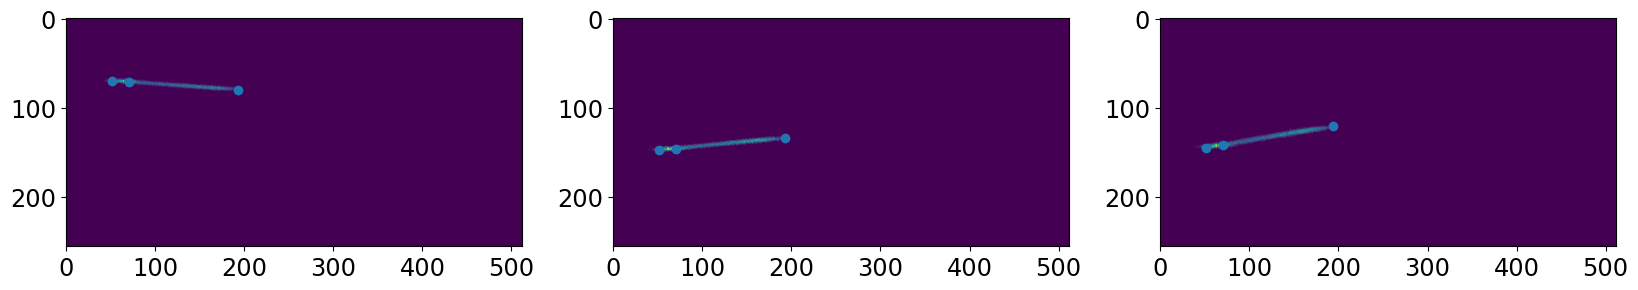

In [34]:
import matplotlib.pyplot as plt

for image, target in train_dataset.take(1):
    points = target.reshape(-1, 3, 2) 
    print(image.shape)
    plt.figure(figsize = (20, 20))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(image[i, :, :])
        plt.scatter(points[i, : , 0], points[i, :, 1])
        
